<h1> Ship Type Prediction </h1>

<p align='justify'>

This Jupyter notebook contains a classification example which is
done with the help of Scikit-Learn library. In this notebook,
the following steps are performed:
</p>

<ol align='justify'>
    <li> The preprocessing i.e. feature generation, filtering and
         interpolation of the data is carried out using the
         PTRAIL Library.
    </li>
    <li> Further, several models like RandomForestClassifier, KMeans
         Classifier etc. are trained using the Scikit-Learn library
         based on the cleaned dataset.
    </li>
    <li>
        Finally, on the interpolated dataset, the type of ships are
        predicted and their accuracy is checked.
    </li>

In [1]:
# Import the dataset.
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

pdf = pd.read_csv('https://raw.githubusercontent.com/YakshHaranwala/PTRAIL/main/examples/data/ships.csv')
np_ships = PTRAILDataFrame(data_set=pdf,
                           latitude='lat',
                           longitude='lon',
                           datetime='Timestamp',
                           traj_id='Name')
np_ships.head()

lat        lon       MMSI NavStatus  \
traj_id      DateTime                                                         
AB RAMANTENN 2017-05-07 00:13:05  11.905735  57.681092  265902200    Moored   
             2017-05-07 00:25:04  11.905740  57.681070  265902200    Moored   
             2017-05-07 00:31:05  11.905792  57.681060  265902200    Moored   
             2017-05-07 01:01:05  11.905650  57.681127  265902200    Moored   
             2017-05-07 01:07:05  11.905700  57.681107  265902200    Moored   

                                  SOG    COG   ShipType  
traj_id      DateTime                                    
AB RAMANTENN 2017-05-07 00:13:05  0.1  170.7  Undefined  
             2017-05-07 00:25:04  0.1  170.7  Undefined  
             2017-05-07 00:31:05  0.1  177.4  Undefined  
             2017-05-07 01:01:05  0.0  175.6  Undefined  
             2017-05-07 01:07:05  0.1  180.8  Undefined

In [2]:
%%time

# Now using PTRAIL, generate distance features and
# run hampel filter on the dataset to remove outliers.
from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.preprocessing.filters import Filters

dist_ships = KinematicFeatures.create_distance_column(np_ships)
dist_ships.head()

CPU times: user 248 ms, sys: 8.07 ms, total: 257 ms
Wall time: 255 ms


lat        lon       MMSI NavStatus  \
traj_id      DateTime                                                         
AB RAMANTENN 2017-05-07 00:13:05  11.905735  57.681092  265902200    Moored   
             2017-05-07 00:25:04  11.905740  57.681070  265902200    Moored   
             2017-05-07 00:31:05  11.905792  57.681060  265902200    Moored   
             2017-05-07 01:01:05  11.905650  57.681127  265902200    Moored   
             2017-05-07 01:07:05  11.905700  57.681107  265902200    Moored   

                                  SOG    COG   ShipType   Distance  
traj_id      DateTime                                               
AB RAMANTENN 2017-05-07 00:13:05  0.1  170.7  Undefined        NaN  
             2017-05-07 00:25:04  0.1  170.7  Undefined   2.457384  
             2017-05-07 00:31:05  0.1  177.4  Undefined   5.883613  
             2017-05-07 01:01:05  0.0  175.6  Undefined  17.391237  
             2017-05-07 01:07:05  0.1  180.8  Undefined   5.970428

In [3]:
%%time

# Now, filter out the outliers using the hampel filter.

filt_ships = Filters.hampel_outlier_detection(dist_ships,
                                              column_name='Distance')
print(f"Length of original DF: {len(dist_ships)}")
print(f"Length of Filtered DF: {len(filt_ships)}")

Length of original DF: 84702
Length of Filtered DF: 61394
CPU times: user 156 ms, sys: 109 ms, total: 265 ms
Wall time: 8.64 s


/home/yjharanwala/Desktop/PTRAIL/ptrail/preprocessing/filters.py:762: UserWarning: If kinematic features have been generated on the dataframe, then make sure to generate them again as outlier detection drops the point from the dataframe and does not run the kinematic features again.
  warnings.warn("If kinematic features have been generated on the dataframe, then make "


In [4]:
# Further more, remove the duplicate points from the
# trajectories.

fp_filt_ships = Filters.remove_duplicates(filt_ships)
print(f"Length of original DF: {len(filt_ships)}")
print(f"Length of Filtered DF: {len(fp_filt_ships)}")

Length of original DF: 61394
Length of Filtered DF: 61102


In [5]:
#Now, remove the trajectories that have fewer than 3 points.
print(f"Before: {len(fp_filt_ships)}")
fp_filt_ships = Filters.remove_trajectories_with_less_points(fp_filt_ships)
print(f"After: {len(fp_filt_ships)}")

Before: 61102
After: 61097


In [6]:
# Now, since the model fitting does not take string values,
# convert the ship types to integers.

fp_filt_ships["ShipType"] = fp_filt_ships["ShipType"].str.strip()
int_test = []
types = fp_filt_ships['ShipType'].tolist()
for i in range(len(fp_filt_ships['ShipType'])):
    if types[i] == 'Tanker':
        int_test.append(0)
    elif types[i] == 'Passenger':
        int_test.append(1)
    elif types[i] == 'HSC':
        int_test.append(2)
    elif types[i] == 'Pilot':
        int_test.append(3)
    elif types[i] == 'SAR':
        int_test.append(4)
    elif types[i] == 'Tug':
        int_test.append(5)
    elif types[i] == 'Cargo':
        int_test.append(6)
    elif types[i] == 'Pleasure':
        int_test.append(7)
    elif types[i] == 'Undefined':
        int_test.append(8)
    elif types[i] == 'Sailing':
        int_test.append(9)
    elif types[i] == 'Law enforcement':
        int_test.append(10)
    elif types[i] == 'Spare 2':
        int_test.append(11)
    elif types[i] == 'Diving':
        int_test.append(12)
    elif types[i] == 'Fishing':
        int_test.append(13)
    elif types[i] == 'Other':
        int_test.append(14)
    else:
        int_test.append(15)
fp_filt_ships['ShipType'] = int_test
fp_filt_ships.head()

index        lat        lon       MMSI  \
traj_id      DateTime                                                      
AB RAMANTENN 2017-05-07 00:13:05      0  11.905735  57.681092  265902200   
             2017-05-07 00:25:04      1  11.905740  57.681070  265902200   
             2017-05-07 00:31:05      2  11.905792  57.681060  265902200   
             2017-05-07 01:07:05      3  11.905700  57.681107  265902200   
             2017-05-07 01:31:04      4  11.905708  57.681045  265902200   

                                 NavStatus  SOG    COG  ShipType  Distance  
traj_id      DateTime                                                       
AB RAMANTENN 2017-05-07 00:13:05    Moored  0.1  170.7         8       NaN  
             2017-05-07 00:25:04    Moored  0.1  170.7         8  2.457384  
             2017-05-07 00:31:05    Moored  0.1  177.4         8  5.883613  
             2017-05-07 01:07:05    Moored  0.1  180.8         8  5.970428  
             2017-05-07 01:31:04    Moored  0.1  173.2         8  6.804183

In [7]:
# Finally, for cubic interpolation, 2 values having
# same traj_id and datetime are not allowed. Hence
# drop those points and convert the DF back to PTRAILDataFrame.

fp_filt_ships = fp_filt_ships.reset_index().drop_duplicates(subset=['traj_id', 'DateTime'])
fp_filt_ships = fp_filt_ships[['traj_id', 'DateTime', 'lat', 'lon', 'ShipType']]
fp_filt_ships = PTRAILDataFrame(data_set=fp_filt_ships,
                              latitude='lat',
                              longitude='lon',
                              datetime='DateTime',
                              traj_id='traj_id')
fp_filt_ships.head()

lat        lon  ShipType
traj_id      DateTime                                           
AB RAMANTENN 2017-05-07 00:13:05  11.905735  57.681092         8
             2017-05-07 00:25:04  11.905740  57.681070         8
             2017-05-07 00:31:05  11.905792  57.681060         8
             2017-05-07 01:07:05  11.905700  57.681107         8
             2017-05-07 01:31:04  11.905708  57.681045         8

In [8]:
# Now, interpolate the filtered dataframe and add points
# to make the trajectories smoother.

from ptrail.preprocessing.interpolation import Interpolation as ip

ip_ships = ip.interpolate_position(fp_filt_ships,
                                   time_jump=15,
                                   ip_type='cubic')

print(f"Length of original DF: {len(fp_filt_ships)}")
print(f"Length of interpolated DF: {len(ip_ships)}")

Length of original DF: 60948
Length of interpolated DF: 83662


In [9]:
# Now, fixing the ShipType column for the interpolated ships dataset.

# The logic behind this is that when a point is added for a
# particular traj_id, then it will retain the ship type as well
# since interpolation is performed on each trajectory. As a result
# the ShipType remains the same and they can be reassigned to
# new points as well.

# Create a list of all unique ids.
ids_ = list(ip_ships.reset_index()['traj_id'].value_counts().keys())

df_chunks = []
# Create a small chunk for each ID, then for the same ID in the
# original dataset, grab the species and then again assign that
# to the interpolated ID.
for i in range(len(ids_)):
    small = ip_ships.reset_index().loc[ip_ships.reset_index()['traj_id'] == ids_[i]]
    spec = fp_filt_ships.reset_index().loc[fp_filt_ships.reset_index()['traj_id'] == ids_[i], 'ShipType']
    small['ShipType'] = spec.value_counts().idxmax()
    df_chunks.append(small)

# Now, convert the dataframe with interpolated species to
# PTRAILDataFrame.
ip_ships = PTRAILDataFrame(data_set=pd.concat(df_chunks),
                         latitude='lat',
                         longitude='lon',
                         traj_id='traj_id',
                         datetime='DateTime')
ip_ships.head()

lat        lon  ShipType
traj_id      DateTime                                           
AB RAMANTENN 2017-05-07 00:13:05  11.905735  57.681092         8
             2017-05-07 00:13:20  11.905732  57.681092         8
             2017-05-07 00:25:04  11.905740  57.681070         8
             2017-05-07 00:25:19  11.905742  57.681069         8
             2017-05-07 00:31:05  11.905792  57.681060         8

In [10]:
# Now, we generate kinematic statistics on the DF and then change the
# representation of the Trajectory to be segment based instead of point based.

stats_df = Statistics.generate_kinematic_stats(dataframe=ip_ships,
                                               target_col_name='ShipType')
pivoted = Statistics.pivot_stats_df(dataframe=stats_df,
                                    target_col_name='ShipType')
pivoted

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,ShipType
traj_id,,,,,,,,,,,,,,,,,,,,,
GOTE II,0.000000,0.028415,0.115705,0.222390,0.316752,0.000000,2.170473,0.154526,0.154095,0.597053,...,-27.000000,-8.188939,0.000000,6.238870,20.502065,-359.912609,333.805144,-1.919112,28.821613,4
NORTHERN KATTEGAT,0.367747,0.761709,1.476793,3.070844,8.511202,0.000000,466.930977,6.321929,20.007278,5.587600,...,-13.615623,-3.890127,-0.007812,3.585384,14.276490,-320.009619,336.494112,0.290888,16.904447,0
VALO,0.032993,0.155589,0.350888,14.292337,42.505153,0.000000,2135.163902,15.092626,54.480844,1.671471,...,-12.857143,-1.871783,0.000000,2.091819,11.838526,-352.886458,210.772502,-1.274359,25.005909,2
DANA,0.108817,0.222390,0.449248,0.765269,1.195425,0.000000,400.072976,2.136360,13.478637,7246.877199,...,-17.165862,-4.319873,0.000000,4.289814,15.623924,-343.195787,174.410732,-0.758736,20.603069,0
FROJA,0.056162,0.139838,0.307472,1.398856,41.425138,0.000000,1157.800513,12.018415,36.986695,0.644748,...,-13.006815,-2.372528,0.000000,2.458402,11.981826,-180.000000,358.398240,-0.109600,16.125163,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAZA,59.740286,85.595937,176.697088,275.716643,688.770919,25.349746,882.034919,259.471571,265.261715,205.447088,...,-6.903933,-1.167804,-0.039921,0.226254,1.930519,-12.000020,11.613094,-0.781932,5.124492,9
RESCUER AMBULANCE,57.276523,60.739935,85.239907,234.247343,348.690942,54.516206,469.872718,157.111975,134.890414,161.934919,...,-1.052801,-0.897456,-0.753843,-0.069228,-0.002428,-2.785896,13.052659,0.206185,3.621717,4
BIPPAN,0.001957,0.007144,0.048383,0.288855,4.864045,0.000000,14.499122,1.595935,4.124439,2.336071,...,-0.231794,-0.062827,-0.000031,0.255319,5.686873,-10.465049,8.324004,0.400376,4.338248,9


In [12]:
# Step-5: Getting the test and train datasets ready.
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(pivoted.drop(columns=['ShipType']), pivoted['ShipType'],
                                                    random_state=7, test_size=0.2)

In [18]:
# Now it is time to train some models and predict
# the ship types.

# 1. RandomForestClassifier model.
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
rf_train_predict = rf_model.predict(X_train)
rf_test_predict = rf_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
rf_train_accuracy = f1_score(y_train, rf_train_predict, average='weighted')
rf_test_accuracy = f1_score(y_test, rf_test_predict, average='weighted')

print('---------------- RandomForest Classifier -----------------')
print(f"The f1_score of RF training is: {round(rf_train_accuracy*100, 2)}%")
print(f"The f1_score of RF testing is: {round(rf_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 2. DecisionTree Classifier model.
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
dt_train_predict = dt_model.predict(X_train)
dt_test_predict = dt_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
dt_train_accuracy = f1_score(y_train, dt_train_predict, average='weighted')
dt_test_accuracy = f1_score(y_test, dt_test_predict, average='weighted')

print('---------------- DecisionTree Classifier -----------------')
print(f"The f1_score of DT training is: {round(dt_train_accuracy*100, 2)}%")
print(f"The f1_score of DT testing is: {round(dt_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 3. Gaussian Naive Bayes model.
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
gnb_train_predict = gnb_model.predict(X_train)
gnb_test_predict = gnb_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
gnb_train_accuracy = f1_score(y_train, gnb_train_predict, average='weighted')
gnb_test_accuracy = f1_score(y_test, gnb_test_predict, average='weighted')

print('----------------- Naive Bayes Classifier -----------------')
print(f"The f1_score of GNB training is: {round(gnb_train_accuracy*100, 2)}%")
print(f"The f1_score of GNB testing is: {round(gnb_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 4. K-Nearest Neighbors Classifier model.

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
knn_train_predict = knn_model.predict(X_train)
knn_test_predict = knn_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
knn_train_accuracy = f1_score(y_train, knn_train_predict, average='weighted')
knn_test_accuracy = f1_score(y_test, knn_test_predict, average='weighted')

print('--------------------- KNN Classifier ---------------------')
print(f"The f1_score of KNN training is: {round(knn_train_accuracy*100, 2)}%")
print(f"The f1_score of KNN testing is: {round(knn_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

---------------- RandomForest Classifier -----------------
The f1_score of RF training is: 100.0%
The f1_score of RF testing is: 48.95%
----------------------------------------------------------

---------------- DecisionTree Classifier -----------------
The f1_score of DT training is: 100.0%
The f1_score of DT testing is: 25.06%
----------------------------------------------------------

----------------- Naive Bayes Classifier -----------------
The f1_score of GNB training is: 70.72%
The f1_score of GNB testing is: 41.05%
----------------------------------------------------------

--------------------- KNN Classifier ---------------------
The f1_score of KNN training is: 47.23%
The f1_score of KNN testing is: 47.51%
----------------------------------------------------------



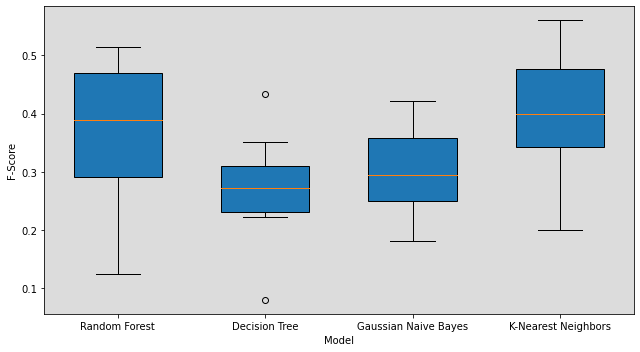

In [17]:
# Let's visualize the scores using box plot of cross validation of the models.
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.simplefilter(category=UserWarning, action="ignore")

names = ["Random Forest", "Decision Tree", "Gaussian Naive Bayes", "K-Nearest Neighbors"]
models = [RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()]

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
for i, name, model in zip(range(0, 5), names, models):
    scores = cross_val_score(model, pivoted.drop(columns=['ShipType']), pivoted['ShipType'],
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True,
               widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F-Score")
ax.set_xlabel("Model")
plt.tight_layout()